In [32]:
import torch
from torch import nn as nn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [33]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1=nn.Linear(1,10)
        self.layer2=nn.Linear(10,1)

    def forward(self,x):
        x=nn.functional.tanh(self.layer1(x))
        x=self.layer2(x)

        return x 

In [34]:
NN=NeuralNetwork()

In [35]:
dim=[0,0.25,.5,.75,1]

xx = torch.linspace(0, dim[-1], 1000)[:, None]
m,n=xx.detach().numpy().shape

sigma_t_matrix=torch.zeros((m,m))
sigma_s_matrix=torch.zeros_like(sigma_t_matrix)
neu_sigma_f_matrix=torch.zeros_like(sigma_t_matrix)

sigma_s=0.334
sigma_s_r=0.00334
neu_sigma_f=.178

sigma_t_fuel=0.415
sigma_t_reflector=0.371
sigma_t_absorber=0.371



for i in range (m):
    if (xx[i]>=dim[0] and xx[i]<dim[1]) or (xx[i]>=dim[2] and xx[i]<dim[3]) or (xx[i]>=dim[3] and xx[i]<dim[4]):
        sigma_t_matrix[i][i]=sigma_t_reflector
        sigma_s_matrix[i][i]=sigma_s_r
    if (xx[i]>=dim[1] and xx[i]<dim[2]) or (xx[i]>=dim[3] and xx[i]<dim[4]):
        sigma_t_matrix[i][i]=sigma_t_fuel
        sigma_s_matrix[i][i]=sigma_s
        neu_sigma_f_matrix[i][i]=neu_sigma_f
   
def loss(xx,k):

    x = torch.tensor(xx, requires_grad=True)
    phi = NN(x)  # Assuming NN is your neural network
    dphi_dx = torch.autograd.grad(phi.sum(), x, create_graph=True)[0]
    ddphi_dxx = torch.autograd.grad(dphi_dx.sum(), x, create_graph=True)[0]

    physics_loss=(ddphi_dxx+torch.matmul(sigma_t_matrix,phi)-torch.matmul(neu_sigma_f_matrix,phi)/k-torch.matmul(sigma_s_matrix,phi))**2
    boundary_loss=phi[0]**2+phi[-1]**2

    total_loss=torch.mean(physics_loss)+boundary_loss


  
    return total_loss

optimizer = torch.optim.LBFGS(NN.parameters())


k=1

def closure():
    optimizer.zero_grad()
    l = loss(xx,k)
    l.backward()

    return l

epochs = 100

for i in range(epochs):
    phi0=NN(xx)
    optimizer.step(closure)
    #print(torch.sum(torch.matmul(neu_sigma_f_matrix,NN(xx)))/torch.sum(torch.matmul(neu_sigma_f_matrix,phi0)))


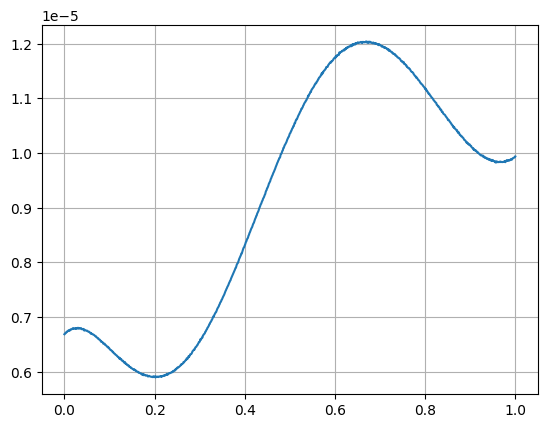

In [36]:
plt.plot(xx,NN(xx).detach().numpy())
plt.grid()
